In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Starting temperature data feature engineering pipeline...
Loading raw data...
Raw data shape: (13149, 31)
Date range: 1990-01-01 to 2025-12-31
Available temperature columns: ['Date/Time', 'Mean Temp (°C)', 'Max Temp (°C)', 'Min Temp (°C)']
Cleaned data shape: (13149, 3)
Missing values per column:
t_mean    7185
t_max     7180
t_min     7144
dtype: int64

Missing data percentages:
  t_mean: 54.6%
  t_max: 54.6%
  t_min: 54.3%
Interpolating 7185 missing temperature values (54.6%)...
Using seasonal averages for 7099 remaining missing values
Final missing values: 0
Adding 8 lag features...
Adding rolling features for 4 windows...

FEATURE ENGINEERING SUMMARY

Target (3 features):
  - t_mean
  - t_max
  - t_min

Temporal (11 features):
  - year
  - month
  - day
  - dayofweek
  - dayofyear
  - sin_doy
  - cos_doy
  - sin_month
  ... and 3 more

Lags (8 features):
  - lag_1
  - lag_2
  - lag_3
  - lag_7
  - lag_14
  - lag_21
  - lag_28
  - lag_365

Rolling Stats (8 features):
  - roll_mean_3

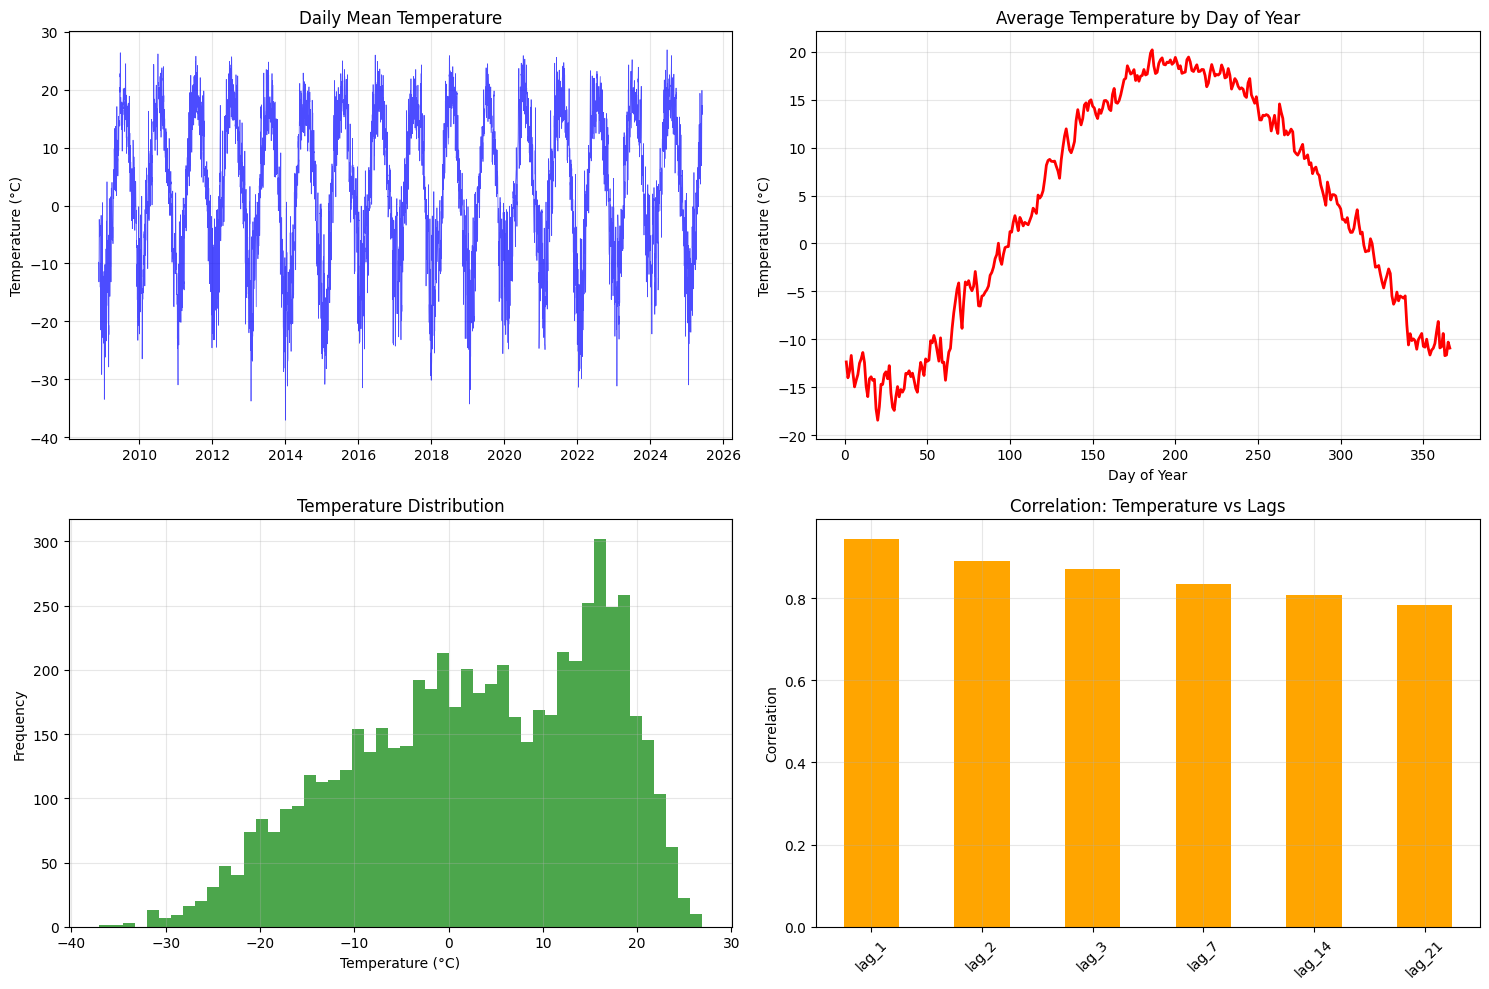

Saved feature overview plot as: feature_overview.png


In [13]:
def load_and_clean_data(filepath="temagami_daily_raw.csv"):
    """Load and perform initial cleaning of ECCC weather data"""
    print("Loading raw data...")
    df = pd.read_csv(filepath)
    
    # Display basic info about the raw data
    print(f"Raw data shape: {df.shape}")
    print(f"Date range: {df['Date/Time'].min()} to {df['Date/Time'].max()}")
    
    # Essential columns with their exact ECCC names
    essential_cols = {
        "Date/Time": "date",
        "Mean Temp (°C)": "t_mean",
        "Max Temp (°C)": "t_max", 
        "Min Temp (°C)": "t_min"
    }
    
    # Check which columns exist and rename
    available_cols = {k: v for k, v in essential_cols.items() if k in df.columns}
    print(f"Available temperature columns: {list(available_cols.keys())}")
    
    df = df.rename(columns=available_cols)
    df = df[list(available_cols.values())]
    
    # Convert date and set as index
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df = df.set_index("date").sort_index()
    
    # Convert temperature columns to numeric, treating empty strings as NaN
    temp_cols = [col for col in df.columns if col.startswith('t_')]
    for col in temp_cols:
        # Replace empty strings with NaN, then convert to float
        df[col] = pd.to_numeric(df[col], errors='coerce').astype("float32")
    
    print(f"Cleaned data shape: {df.shape}")
    print(f"Missing values per column:")
    missing_counts = df.isnull().sum()
    print(missing_counts)
    
    # Show percentage of missing data
    print(f"\nMissing data percentages:")
    for col in temp_cols:
        pct_missing = 100 * missing_counts[col] / len(df)
        print(f"  {col}: {pct_missing:.1f}%")
    
    return df

def add_data_quality_flags(df):
    """Add flags for data quality issues"""
    df = df.copy()
    
    # Flag missing values before interpolation
    if 't_mean' in df.columns:
        df['missing_t_mean'] = df['t_mean'].isnull()
        
        # Flag extreme values (beyond reasonable temperature ranges for Canada)
        df['extreme_hot'] = df['t_mean'] > 45  # > 45°C is extremely rare
        df['extreme_cold'] = df['t_mean'] < -50  # < -50°C is extremely rare
        
        # Count extreme values
        n_hot = df['extreme_hot'].sum()
        n_cold = df['extreme_cold'].sum()
        if n_hot > 0 or n_cold > 0:
            print(f"Found {n_hot} extremely hot days (>45°C) and {n_cold} extremely cold days (<-50°C)")
    
    # Flag impossible min/max relationships
    if 't_max' in df.columns and 't_min' in df.columns:
        df['invalid_minmax'] = df['t_min'] > df['t_max']
        n_invalid = df['invalid_minmax'].sum()
        if n_invalid > 0:
            print(f"Found {n_invalid} days where min temp > max temp")
        
        # Also flag if mean is outside min-max range
        if 't_mean' in df.columns:
            df['invalid_mean'] = (df['t_mean'] < df['t_min']) | (df['t_mean'] > df['t_max'])
            n_invalid_mean = df['invalid_mean'].sum()
            if n_invalid_mean > 0:
                print(f"Found {n_invalid_mean} days where mean temp is outside min-max range")
    
    return df

def interpolate_missing_values(df):
    """Advanced missing value handling"""
    if 't_mean' not in df.columns:
        print("No mean temperature column found, skipping interpolation")
        return df
    
    df = df.copy()
    
    missing_mask = df['t_mean'].isnull()
    n_missing = missing_mask.sum()
    
    if n_missing == 0:
        print("No missing temperature values found")
        return df
    
    print(f"Interpolating {n_missing} missing temperature values ({100*n_missing/len(df):.1f}%)...")
    
    # Strategy 1: Linear interpolation for short gaps (≤ 7 days)
    df['t_mean_interp'] = df['t_mean'].interpolate(method='linear', limit=7)
    
    # Strategy 2: For longer gaps, use seasonal average
    still_missing = df['t_mean_interp'].isnull()
    if still_missing.sum() > 0:
        print(f"Using seasonal averages for {still_missing.sum()} remaining missing values")
        
        # Create month-day key for seasonal averaging
        df['month_day'] = df.index.strftime('%m-%d')
        seasonal_avg = df.groupby('month_day')['t_mean_interp'].transform('mean')
        df['t_mean_interp'] = df['t_mean_interp'].fillna(seasonal_avg)
        
        # Final fallback: forward/backward fill
        still_missing_final = df['t_mean_interp'].isnull()
        if still_missing_final.sum() > 0:
            print(f"Forward/backward filling {still_missing_final.sum()} remaining values")
            df['t_mean_interp'] = df['t_mean_interp'].fillna(method='ffill').fillna(method='bfill')
    
    # Replace original with interpolated
    df['t_mean'] = df['t_mean_interp']
    df.drop(columns=['t_mean_interp', 'month_day'], inplace=True, errors='ignore')
    
    final_missing = df['t_mean'].isnull().sum()
    print(f"Final missing values: {final_missing}")
    
    return df

def add_temporal_features(df):
    """Add comprehensive temporal features"""
    df = df.copy()
    
    # Basic date components
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    
    # Cyclical encodings for seasonality
    # Day of year (annual cycle) - accounts for leap years
    doy = df.index.dayofyear
    df['sin_doy'] = np.sin(2 * np.pi * doy / 365.25).astype('float32')
    df['cos_doy'] = np.cos(2 * np.pi * doy / 365.25).astype('float32')
    
    # Month (another way to capture seasonality)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12).astype('float32')
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12).astype('float32')
    
    # Day of week (weekly patterns, though less relevant for temperature)
    df['sin_dow'] = np.sin(2 * np.pi * df['dayofweek'] / 7).astype('float32')
    df['cos_dow'] = np.cos(2 * np.pi * df['dayofweek'] / 7).astype('float32')
    
    return df

def add_lag_features(df, target_col='t_mean'):
    """Add lagged temperature features"""
    if target_col not in df.columns:
        print(f"Target column {target_col} not found, skipping lag features")
        return df
    
    df = df.copy()
    
    # Short-term lags (weather persistence)
    short_lags = [1, 2, 3, 7]  # 1-3 days, 1 week
    
    # Medium-term lags (weather patterns)
    medium_lags = [14, 21, 28]  # 2, 3, 4 weeks
    
    # Long-term lags (seasonal patterns) - be careful with memory
    long_lags = [365]  # 1 year ago (removed 730 to save memory)
    
    all_lags = short_lags + medium_lags + long_lags
    
    print(f"Adding {len(all_lags)} lag features...")
    for lag in all_lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag).astype('float32')
    
    return df

def add_rolling_features(df, target_col='t_mean'):
    """Add rolling window statistics"""
    if target_col not in df.columns:
        print(f"Target column {target_col} not found, skipping rolling features")
        return df
    
    df = df.copy()
    
    windows = [3, 7, 14, 30]  # Reduced to save memory
    
    print(f"Adding rolling features for {len(windows)} windows...")
    for window in windows:
        # Rolling mean
        df[f'roll_mean_{window}'] = df[target_col].rolling(window, min_periods=1).mean().astype('float32')
        
        # Rolling std (temperature variability)
        df[f'roll_std_{window}'] = df[target_col].rolling(window, min_periods=1).std().astype('float32')
        
        # Temperature anomaly (deviation from rolling mean)
        df[f'anomaly_{window}'] = (df[target_col] - df[f'roll_mean_{window}']).astype('float32')
    
    return df

def add_trend_features(df, target_col='t_mean'):
    """Add trend and change-point features"""
    if target_col not in df.columns:
        print(f"Target column {target_col} not found, skipping trend features")
        return df
    
    df = df.copy()
    
    # Temperature differences (rate of change)
    for lag in [1, 7]:
        df[f'diff_{lag}'] = df[target_col].diff(lag).astype('float32')
    
    # Temperature acceleration (second derivative)
    df['accel_1'] = df[target_col].diff().diff().astype('float32')
    
    return df

def create_feature_summary(df):
    """Create a summary of engineered features"""
    feature_groups = {
        'Target': [col for col in df.columns if col.startswith('t_') and not any(x in col for x in ['lag_', 'roll_', 'diff_'])],
        'Temporal': [col for col in df.columns if any(x in col for x in ['sin_', 'cos_', 'year', 'month', 'day'])],
        'Lags': [col for col in df.columns if col.startswith('lag_')],
        'Rolling Stats': [col for col in df.columns if col.startswith('roll_')],
        'Anomalies': [col for col in df.columns if col.startswith('anomaly_')],
        'Trends': [col for col in df.columns if any(x in col for x in ['diff_', 'accel_'])],
        'Quality Flags': [col for col in df.columns if any(x in col for x in ['missing_', 'extreme_', 'invalid_'])]
    }
    
    print("\n" + "="*50)
    print("FEATURE ENGINEERING SUMMARY")
    print("="*50)
    
    total_features = 0
    for group, features in feature_groups.items():
        if features:
            print(f"\n{group} ({len(features)} features):")
            for feat in features[:8]:  # Show first 8
                print(f"  - {feat}")
            if len(features) > 8:
                print(f"  ... and {len(features) - 8} more")
            total_features += len(features)
    
    print(f"\nTotal features: {total_features}")
    print(f"Data range: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Total observations: {len(df)}")
    
    return feature_groups

def plot_feature_overview(df):
    """Create basic plots to understand the data"""
    if 't_mean' not in df.columns:
        print("No temperature data to plot")
        return
    
    # Check if we have valid temperature data
    valid_temp = df['t_mean'].dropna()
    if len(valid_temp) == 0:
        print("No valid temperature data to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Temperature time series
    axes[0,0].plot(df.index, df['t_mean'], alpha=0.7, linewidth=0.5, color='blue')
    axes[0,0].set_title('Daily Mean Temperature')
    axes[0,0].set_ylabel('Temperature (°C)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Seasonal pattern
    seasonal_avg = df.groupby(df.index.dayofyear)['t_mean'].mean()
    seasonal_avg.plot(ax=axes[0,1], color='red', linewidth=2)
    axes[0,1].set_title('Average Temperature by Day of Year')
    axes[0,1].set_xlabel('Day of Year')
    axes[0,1].set_ylabel('Temperature (°C)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Temperature distribution
    df['t_mean'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='green')
    axes[1,0].set_title('Temperature Distribution')
    axes[1,0].set_xlabel('Temperature (°C)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    
    # Correlation with lag features
    lag_cols = [col for col in df.columns if col.startswith('lag_')]
    if lag_cols:
        # Select a subset of lag columns for correlation
        selected_lags = lag_cols[:6]  # First 6 lag features
        corr_data = df[['t_mean'] + selected_lags].corr()['t_mean'][1:].sort_values(ascending=False)
        corr_data.plot(kind='bar', ax=axes[1,1], color='orange')
        axes[1,1].set_title('Correlation: Temperature vs Lags')
        axes[1,1].set_ylabel('Correlation')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'No lag features\navailable', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Lag Feature Correlations')
    
    plt.tight_layout()
    plt.savefig('feature_overview.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved feature overview plot as: feature_overview.png")

def main():
    """Main feature engineering pipeline"""
    print("Starting temperature data feature engineering pipeline...")
    print("="*60)
    
    try:
        # Load and clean data
        df = load_and_clean_data("temagami_daily_raw.csv")
        
        # Check if we have temperature data
        if 't_mean' not in df.columns:
            print("ERROR: No mean temperature column found!")
            print("Available columns:", list(df.columns))
            return None, None
        
        # Add data quality flags
        df = add_data_quality_flags(df)
        
        # Handle missing values
        df = interpolate_missing_values(df)
        
        # Add all feature groups
        df = add_temporal_features(df)
        df = add_lag_features(df)
        df = add_rolling_features(df)
        df = add_trend_features(df)
        
        # Create feature summary
        feature_groups = create_feature_summary(df)
        
        # Drop rows with NaN values (caused by lags and rolling windows)
        print(f"\nBefore dropping NaN: {len(df)} rows")
        df_clean = df.dropna()
        print(f"After dropping NaN: {len(df_clean)} rows")
        
        if len(df_clean) == 0:
            print("WARNING: No rows remaining after dropping NaN values!")
            print("This might indicate issues with the data or feature engineering.")
            # Save intermediate version for debugging
            df.to_csv("temagami_features_with_nan.csv")
            print("Saved intermediate data (with NaN) to: temagami_features_with_nan.csv")
            return df, feature_groups
        
        dropped = len(df) - len(df_clean)
        print(f"Dropped {dropped} rows ({100 * dropped / len(df):.1f}%)")
        
        # Save processed data
        df_clean.to_csv("temagami_features.csv")
        print(f"\nSaved clean features to: temagami_features.csv")
        
        # Basic statistics
        print(f"\nFinal dataset statistics:")
        print(f"Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
        print(f"Temperature range: {df_clean['t_mean'].min():.1f}°C to {df_clean['t_mean'].max():.1f}°C")
        print(f"Average temperature: {df_clean['t_mean'].mean():.1f}°C")
        
        # Create visualization
        plot_feature_overview(df_clean)
        
        return df_clean, feature_groups
        
    except Exception as e:
        print(f"ERROR in pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    df_features, feature_groups = main()